In [31]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imageio

In [45]:
del yolov0
yolov0 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (3,3), input_shape=(256, 256, 3), activation=tf.nn.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(12, (3,3), activation=tf.nn.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(24, (3,3), activation=tf.nn.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(36, (3,3), activation=tf.nn.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(72, (3,3), activation=tf.nn.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(144, (3,3), activation=tf.nn.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24),
    tf.keras.layers.Dense(5)
])

In [46]:
yolov0.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 6)       168       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 127, 127, 6)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 125, 125, 12)      660       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 24)        2616      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 24)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 36)       

In [47]:
optimizer = tf.optimizers.Adam()
loss_fn = tf.keras.losses.MeanSquaredError()
@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        y_predict = yolov0.call(x_batch)
        loss = loss_fn(y_batch, y_predict)
    grads = tape.gradient(loss, yolov0.trainable_weights)
    optimizer.apply_gradients(zip(grads, yolov0.trainable_weights))
    return y_predict, loss

In [6]:
train_step(tf.random.normal(shape=(1, 256, 256, 3)), tf.Variable([[1, 2, 3, 4, 5]]))

(<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.24992967,  0.01925555,  0.00347478, -0.21433724,  0.08285267]],
       dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([11.280763], dtype=float32)>)

In [7]:
def load_dataset():
    images, labels = [], []
    with open('./index.txt', 'r') as f:
        for line in f.readlines():
            splited_line = line.strip().split(",")
            uid = splited_line[0]
            x = float(splited_line[1]) / 256
            y = float(splited_line[2]) / 256
            w = float(splited_line[3]) / 256
            h = float(splited_line[4]) / 256
            c = int(splited_line[5])
            image = imageio.imread("pi/%s.png" % uid)
            images.append(image.tolist())
            labels.append([x, y, w, h, c])
    return images, labels

In [8]:
images, labels = load_dataset()
images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)

image_dataset = tf.data.Dataset.from_tensor_slices(images_tensor)
image_dataset = image_dataset.map(lambda x: x / 255.0)
y_dataset = tf.data.Dataset.from_tensor_slices(labels_tensor)
dataset = tf.data.Dataset.zip((image_dataset, y_dataset))

dataset = dataset.batch(64, drop_remainder=True)


In [60]:
for i in range(4):
    for x, y in dataset:
        y, loss = train_step(x, y)
        print(loss.numpy())

0.0011785037
0.0008751663
0.0009207055
0.0010485287
0.0013718933
0.00074979773
0.001220115
0.0007748621
0.0009807975
0.0008103702
0.00093231007
0.0010807719
0.0009617391
0.0013228509
0.0010649924
0.0008749898
0.0007962638
0.0010098803
0.0012908131
0.0006645647
0.0011958478
0.0007126386
0.0009611784
0.00075490936
0.0008531775
0.001029244
0.0008298102
0.0012539492
0.0009792588
0.0007724542
0.00073312747
0.00088380155
0.001198307
0.0005899535
0.0010790601
0.00071603665
0.00082438736
0.0007439785
0.00080760324
0.0009664757
0.00080131093
0.001122152
0.0009626802
0.0006264152
0.00068995985
0.00081358734
0.0010513898
0.00061579933
0.00090402167
0.0007259223
0.00074644305
0.00070252793
0.00091810443
0.0008370943
0.00088462344
0.0010073713


In [54]:
for i in dataset.take(1):
    image = i[0][0]
    label = i[1][0]

In [55]:
res = yolov0(np.array([image]))

In [56]:
img = np.array(image * 255.0, dtype=np.uint8)

In [57]:
(x, y, w, h) = label[0: 4] * 256
(x_, y_, w_, h_) = res[0][0: 4] * 256

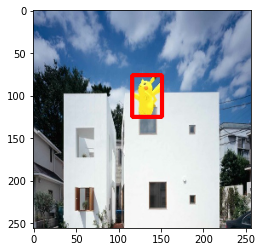

In [58]:
plt.imshow(cv2.rectangle(img, (int(x), int(y)), (int(x + w), int(y + h)), color=(255,0,0), thickness=3))

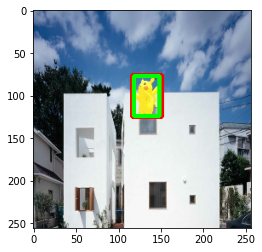

In [59]:
plt.imshow(cv2.rectangle(img, (int(x_), int(y_)), (int(x_ + w_), int(y_ + h_)), color=(0,255,0), thickness=3))